In [503]:
import copy
import glob
import math
import warnings
from functools import partial
from typing import Any

import einops
import h5py
import hdf5plugin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from einops import rearrange, repeat
from PIL import Image, ImageFilter
from torch.nn import init
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.auto import tqdm

In [403]:
class CDS(Dataset):
    def __init__(
        self, low_ppc, high_ppc, j, total_size, out_dir, normalize=True, transform=None
    ):

        super().__init__()
        self.total_size = total_size
        self.low_ppc = low_ppc
        self.high_ppc = high_ppc
        self.transform = transform
        self.mean = {}
        self.std = {}

        self.images = {}

        for ppc in tqdm([low_ppc, high_ppc]):
            self.images[ppc] = {}
            js = []
            for i in tqdm(range(1, total_size + 1)):
                with h5py.File(f"{out_dir}/out-{ppc}.{str(i).zfill(3)}", "r") as f:
                    js.append(f[j][:])
            self.images[ppc] = np.stack(js)
            if normalize:
                self.mean[ppc] = self.images[ppc].mean()
                self.std[ppc] = self.images[ppc].std()
                self.images[ppc] = (self.images[ppc] - self.mean[ppc]) / self.std[ppc]

    def __len__(self):
        return self.total_size

    def __getitem__(self, i):
        lr = self.images[self.low_ppc][i]
        hr = self.images[self.high_ppc][i]

        if self.transform:
            lr = self.transform(lr)
            hr = self.transform(hr)

        return lr, hr

In [658]:
osize = (125, 133)
tfm = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Resize(tuple((np.array(osize) * 1.1).astype(int))),
        # transforms.TenCrop(osize),
        # transforms.Lambda(lambda crops: torch.stack(crops)),
    ]
)
ds = CDS(160, 320, "jx", 148, "../out", normalize=True, transform=tfm)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

In [659]:
def unpack(x):
    x1, x2 = list(zip(*x))
    x1, x2 = torch.stack(x1), torch.stack(x2)
    return x1, x2

In [660]:
train_len = int(len(ds) * 0.95)
train_ds, test_ds = random_split(ds, (train_len, len(ds) - train_len))
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=unpack)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True, collate_fn=unpack)

In [661]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [662]:
class View(nn.Module):
    def __init__(self, *shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, input):
        return input.view(*self.shape)


class ResidualBlock(nn.Module):
    def __init__(self, channels):

        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(channels, channels, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn(self.conv1(x)))
        out = self.bn(self.conv2(out))
        out = out + residual
        out = F.relu(out)
        return out


class ConvXCoder(nn.Module):
    def __init__(
        self,
        im_shape,
        in_channels,
        out_channels,
        hidden_channels,
        num_res_blocks,
        device,
    ):
        super().__init__()
        self.im_shape = im_shape
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.num_res_blocks = num_res_blocks

        self.conv_in = nn.Conv2d(in_channels, hidden_channels, (3, 3), padding=1).to(
            device
        )
        self.res_blocks = nn.ModuleList(
            [ResidualBlock(hidden_channels).to(device) for _ in range(num_res_blocks)]
        )
        self.bn = nn.BatchNorm2d(hidden_channels).to(device)
        self.conv_out = nn.Conv2d(hidden_channels, out_channels, (3, 3), padding=1).to(
            device
        )

        if im_shape is not None:
            self.view = View(-1, self.in_channels, *self.im_shape)
        else:
            self.view = None

    def forward(self, x):
        if self.view:
            x = self.view(x)

        x = self.conv_in(x)
        x = F.relu(self.bn(x))

        for i in range(self.num_res_blocks):
            x = self.res_blocks[i](x)

        x = self.conv_out(x)
        return x

In [663]:
class MS_SSIM_L1_Loss(nn.Module):
    def __init__(
        self,
        gaussian_sigmas=[0.5, 1.0, 2.0, 4.0, 8.0],
        data_range=1.0,
        K=(0.01, 0.03),
        alpha=0.025,
        compensation=200.0,
        cuda_dev=0,
    ):
        super().__init__()
        self.DR = data_range
        self.C1 = (K[0] * data_range) ** 2
        self.C2 = (K[1] * data_range) ** 2
        self.pad = int(2 * gaussian_sigmas[-1])
        self.alpha = alpha
        self.compensation = compensation
        filter_size = int(4 * gaussian_sigmas[-1] + 1)
        g_masks = torch.zeros((3 * len(gaussian_sigmas), 1, filter_size, filter_size))
        for idx, sigma in enumerate(gaussian_sigmas):
            # r0,g0,b0,r1,g1,b1,...,rM,gM,bM
            g_masks[3 * idx + 0, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3 * idx + 1, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
            g_masks[3 * idx + 2, 0, :, :] = self._fspecial_gauss_2d(filter_size, sigma)
        self.g_masks = g_masks.cuda(cuda_dev)

    def _fspecial_gauss_1d(self, size, sigma):
        coords = torch.arange(size).to(dtype=torch.float)
        coords -= size // 2
        g = torch.exp(-(coords**2) / (2 * sigma**2))
        g /= g.sum()
        return g.reshape(-1)

    def _fspecial_gauss_2d(self, size, sigma):
        gaussian_vec = self._fspecial_gauss_1d(size, sigma)
        return torch.outer(gaussian_vec, gaussian_vec)

    def forward(self, x, y):
        b, c, h, w = x.shape
        mux = F.conv2d(x, self.g_masks, groups=1, padding=self.pad)
        muy = F.conv2d(y, self.g_masks, groups=1, padding=self.pad)

        mux2 = mux * mux
        muy2 = muy * muy
        muxy = mux * muy

        sigmax2 = F.conv2d(x * x, self.g_masks, groups=1, padding=self.pad) - mux2
        sigmay2 = F.conv2d(y * y, self.g_masks, groups=1, padding=self.pad) - muy2
        sigmaxy = F.conv2d(x * y, self.g_masks, groups=1, padding=self.pad) - muxy

        # l(j), cs(j) in MS-SSIM
        l = (2 * muxy + self.C1) / (mux2 + muy2 + self.C1)  # [B, 15, H, W]
        cs = (2 * sigmaxy + self.C2) / (sigmax2 + sigmay2 + self.C2)

        lM = l[:, -1, :, :] * l[:, -2, :, :] * l[:, -3, :, :]
        PIcs = cs.prod(dim=1)

        loss_ms_ssim = 1 - lM * PIcs  # [B, H, W]

        loss_l1 = F.l1_loss(x, y, reduction="none")  # [B, 3, H, W]
        # average l1 loss in 3 channels
        gaussian_l1 = F.conv2d(
            loss_l1,
            self.g_masks.narrow(dim=0, start=-3, length=3),
            groups=1,
            padding=self.pad,
        ).mean(
            1
        )  # [B, H, W]

        loss_mix = self.alpha * loss_ms_ssim + (1 - self.alpha) * gaussian_l1 / self.DR
        loss_mix = self.compensation * loss_mix

        return loss_mix.mean()

In [666]:
im_channels = 1
hidden_channels = 2
encoder = ConvXCoder(osize, im_channels, hidden_channels, hidden_channels, 3, device)
decoder = ConvXCoder(osize, hidden_channels, im_channels, hidden_channels, 3, device)
autoencoder = nn.Sequential(encoder, decoder).to(device)

In [669]:
autoencoder.load_state_dict(torch.load("../models/convxcoder/160-320-3l-2c.pt"))
autoencoder.eval();

In [634]:
loss_fn = lambda x, y: MS_SSIM_L1_Loss()(x, y) * 0.7 + nn.L1Loss()(x, y) * 0.3
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [635]:
# losses = []

epochs = 500

for e in (pbar := tqdm(range(epochs))):

    for i, (x, y) in enumerate(train_dl):
        x, y = x.to(device), y.to(device)

        x = x.reshape(-1, 1, *osize)
        y = y.reshape(-1, 1, *osize)

        pred = autoencoder(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        nloss = loss.item() / x.shape[0]

        losses.append(nloss)

        if i % 50 == 0:
            pbar.set_description(f"loss: {nloss:.2e}")

  0%|          | 0/500 [00:00<?, ?it/s]

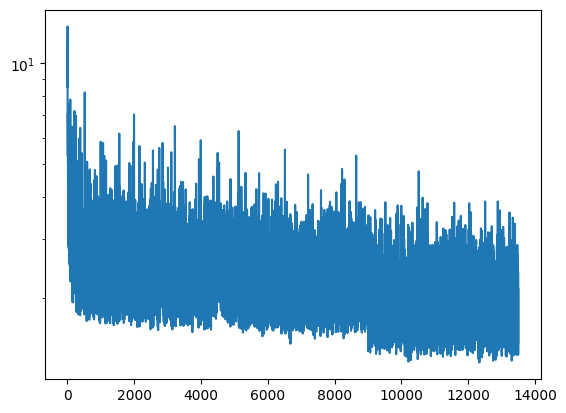

In [637]:
plt.plot(losses)
plt.yscale("log")

In [670]:
autoencoder.eval()
x, y = next(iter(test_dl))
x = x.reshape(-1, 1, *osize)
pred = autoencoder(x.to(device))
x = x.reshape(y.shape)
pred = pred.reshape(y.shape)

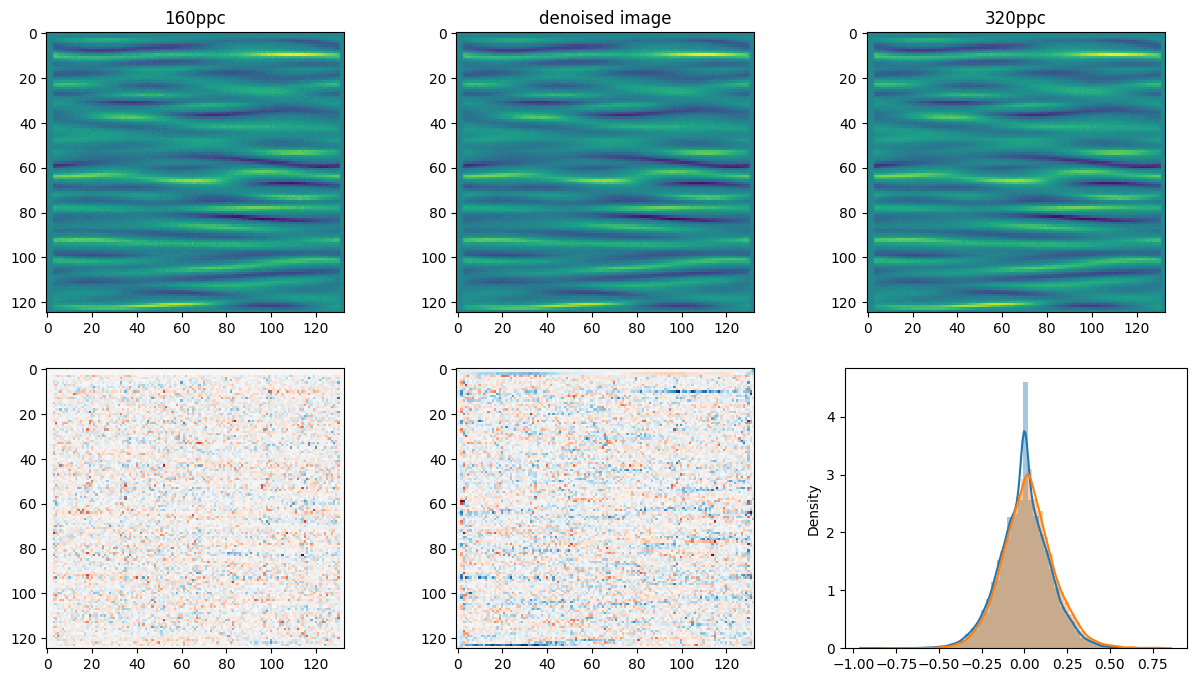

In [677]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ix = 0

ax[0, 0].imshow(x[ix][0].cpu().detach().numpy(), interpolation="none")
ax[0, 1].imshow(pred[ix][0].cpu().detach().numpy(), interpolation="none")
ax[0, 2].imshow(y[ix][0].cpu().detach().numpy(), interpolation="none")

ax[0, 0].set_title("160ppc")
ax[0, 1].set_title("denoised image")
ax[0, 2].set_title("320ppc")

ax[1, 0].imshow(
    (x[ix][0] - y[ix][0]).cpu().detach().numpy(),
    interpolation="none",
    cmap="RdBu",
    norm=matplotlib.colors.CenteredNorm(0),
)
ax[1, 1].imshow(
    (pred[ix][0].cpu() - y[ix][0]).cpu().detach().numpy(),
    interpolation="none",
    cmap="RdBu",
    norm=matplotlib.colors.CenteredNorm(0),
)
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=UserWarning)
    sns.distplot((x[ix][0] - y[ix][0]).cpu().detach().numpy(), ax=ax[1, 2])
    sns.distplot((pred[ix][0].cpu() - y[ix][0]).cpu().detach().numpy(), ax=ax[1, 2]);

In [569]:
torch.save(autoencoder.state_dict(), "../models/convxcoder/160-320-3l.pt")